In [1]:
import os
import numpy as np
from importlib import reload
from dataclasses import *

import AvantgardeModelUtils
reload(AvantgardeModelUtils)
from AvantgardeModelUtils import *

BINARY_CLUSTER_BINS = np.arange(0, 1, 0.5)

def Connectivity(counts):
    counts = np.array(counts)
    s = counts.sum()
    return (s - counts.size) / (s - 1)


class Property(object):
    def __init__(self, label, func, dtype=np.float64):
        self.label = label
        self.func = func
        self.stats = np.empty(0, dtype=dtype)
    
    def AddCounts(self, counts: np.ndarray):
        self.stats = np.append(self.stats, self.func(counts))
        
    def __repr__(self):
        return self.label + ": " + str(np.round(self.stats, 3))

    
@dataclass
class ClusterProperties:
    maximum: Property 
    minimum: Property
    mean: Property
    median: Property
    connectivity: Property
    spread: Property
    
    def AddCounts(self, counts: np.ndarray):
        for field in fields(self):
            attr = getattr(self, field.name)
            attr.AddCounts(counts)
            
    def __repr__(self):
        outstr = "Cluster Properties:\n"
        for field in fields(self):
            outstr += "  " + str(getattr(self, field.name)) + "\n"
        return outstr
    
    
def CreateClusterProperties():
    maximum = Property("Max", np.max, dtype=np.int32)
    minimum = Property("Min", np.min, dtype=np.int32)
    mean = Property("Mean", np.mean)
    median = Property("Median", np.median, dtype=np.int32)
    std = Property("Stddev", np.std)
    spread = Property("Spread", lambda x: np.max(x) - np.min(x), dtype=np.int32)
    connectivity = Property("Connectivity", Connectivity)
    return ClusterProperties(maximum, minimum, mean, median, connectivity, spread)


# Test
properties = CreateClusterProperties()
properties.AddCounts(np.random.randint(10, size=10))
properties.AddCounts(np.random.randint(10, size=10))
print("Test\n-----")
print(properties)

Test
-----
Cluster Properties:
  Max: [9 9]
  Min: [2 1]
  Mean: [5.5 4.3]
  Median: [5.  3.5]
  Connectivity: [0.833 0.786]
  Spread: [7 8]



In [2]:
file = "../data/constant_avantgarde/agent_data_800steps_1.csv"
file = "../data/avantgardeGoal/100k/data_improved_avantgarde-uniform_affinity-uniform_goal-uniform_100.csv"
file = "../data/distributions/agent_data_1000steps_a-normal-10-04.csv"

columns = ["step", "id", "avantgarde", "affinity", "affinityGoal", "seed"]
data = LoadSimulation(file, columns=columns)

In [3]:
file = "../data/distributions/agent_data_1000steps_a-normal-04-02.csv"
#file = "../data/constant_avantgarde/agent_data_800steps_1.csv"
#file = "../data/simplified/agent_data_uniform.csv"
data = LoadSimulation(file, columns=["step", "id", "avantgarde", "affinity", "affinityGoal", "seed"])

In [4]:
np.unique(data.seed)

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200], dtype=int64)

In [5]:
LAST_STEP = 1000

sample = data.query("seed == 100")
grid = Grid(Avantgarde(sample, LAST_STEP))

In [6]:
data

,step,id,affinity,avantgarde,affinityGoal,seed
0,0,1,0.660911,0.268373,0.190313,100
1,0,2,0.645691,0.357697,0.967600,100
2,0,3,0.972755,0.479214,0.526845,100
3,0,4,0.523990,0.727542,0.172707,100
4,0,5,0.199381,0.577390,0.893169,100
...,...,...,...,...,...,...
2019995,1000,9996,0.461939,0.016985,0.770322,200
2019996,1000,9997,0.485050,0.767882,0.183342,200
2019997,1000,9998,0.499483,0.087925,0.791582,200
2019998,1000,9999,0.508080,0.455917,0.849198,200


In [8]:
beta_dist_path = "../data/distributions/beta/"

def find_between(s, start, end):
    return (s.split(start))[1].split(end)[0]

@dataclass
class BetaPdf:
    # definition see WIKI
    mean: float
    alpha: float
    beta: float

def GetBetaPdfFromFileName(fname):
    a = float(find_between(fname, "a-", "_"))
    b = float(find_between(fname, "b-", "_"))
    m = float(find_between(fname, "m-", ".csv"))
    return BetaPdf(m, a, b)
        
beta_files = []
for file in os.listdir(beta_dist_path):
    betaPdf = GetBetaPdfFromFileName(file)
    if "agent_data" in file:
        beta_files.append((file, betaPdf))

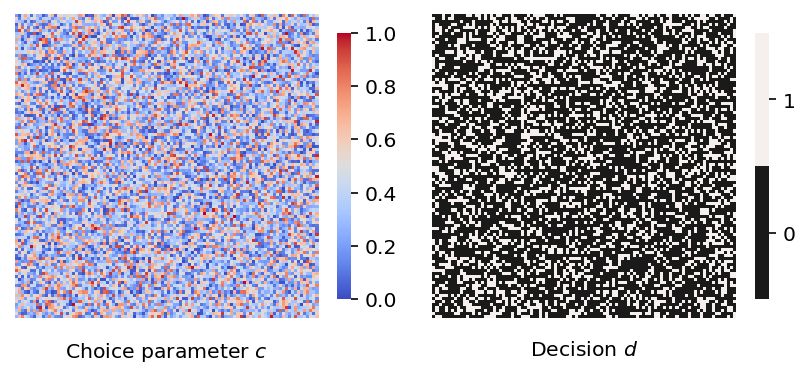

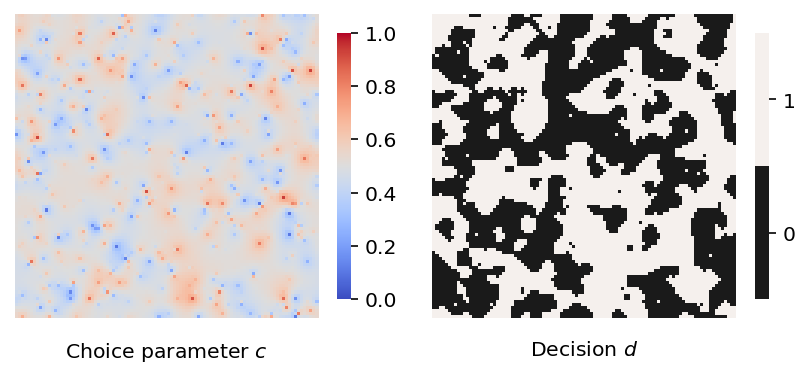

In [9]:
file, dist = beta_files[2]

sample = LoadSimulation(beta_dist_path + file, columns=columns).query("seed == 100")
ShowState(Grid(Avantgarde(sample, 0)))
ShowState(Grid(Choice(sample, 100)))

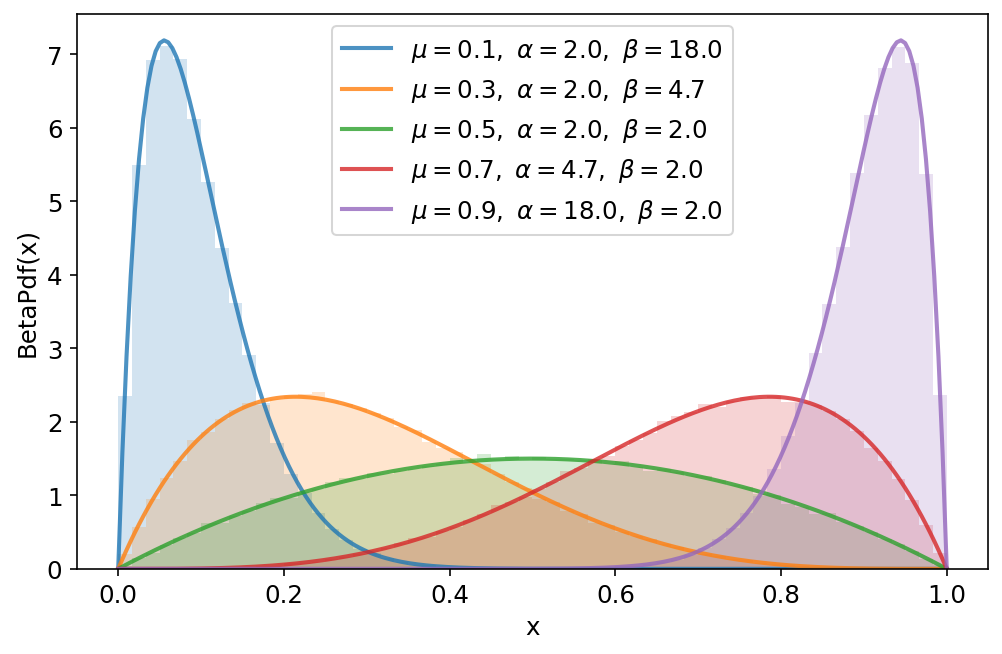

In [16]:
from scipy.stats import beta

plt.rcParams.update({"font.size": 12, "figure.dpi": 147})

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

beta_files_filtered = [*(filter(lambda x: \
                                (x[1].alpha == 2.) or \
                                (x[1].beta == 2.), beta_files))]
beta_files_filtered.sort(key = lambda x: x[1].mean)

plt.figure(figsize=(8, 5))

for (file, dist), color in zip(beta_files_filtered[1::4], colors):
    sample = LoadSimulation(beta_dist_path + file, columns=columns)
    nbins = 60
    bins = np.linspace(0.0, 1.0, nbins+1)

    counts = []
    for seed in sample.get("seed").unique()[:10]:
        selection = sample.query("seed == @seed")
        avantgarde_ = selection.get("avantgarde")
        selection_counts, _ = np.histogram(avantgarde_, bins) 
        counts.append(selection_counts)
    counts = np.array(counts)

    x = np.linspace(0.0, 1.0, 200)
    plt.plot(x, beta.pdf(x, dist.alpha, dist.beta), 
             lw=2, alpha=0.8, color=color, 
             label=fr'$\mu={dist.mean:.1f},\ \alpha={dist.alpha:.1f},\ \beta={dist.beta:.1f}$')
             #label=f'Beta({dist.alpha:.2f},{dist.beta:.2f}), m={dist.mean:.2f}')
    
    density = counts / (counts.sum(axis=1)[:, None] * np.diff(bins))
    plt.stairs(density.mean(axis=0), bins, 
               fill=True, alpha=0.2, color=color)
    
    
plt.ylabel("BetaPdf(x)")
plt.xlabel("x")
plt.legend()
plt.show()

In [17]:
@dataclass
class ClusterAnalysis:
    distribution: object
    positive: ClusterProperties
    negative: ClusterProperties
        
    def AddCounts(self, counts: dict):
        self.positive.AddCounts(counts[1])
        self.negative.AddCounts(counts[2])
        return self
        
    def __repr__(self):
        s = "Cluster Analysis for "
        s += f"Distribution = {self.distribution}\n"
        s += "-----" * 6 + "\n"
        s += "Positive " + str(self.positive)
        s += "Negative " + str(self.negative)
        return s
    
    @classmethod
    def GetInstance(cls, distribution: object):
        return ClusterAnalysis(distribution,
            CreateClusterProperties(), CreateClusterProperties())
    

# Test
_results = ClusterAnalysis(BetaPdf(1.0, 1.0, 1.0),
    CreateClusterProperties(), CreateClusterProperties())

# print(_results)

In [18]:
@dataclass
class NormalPdf:
    mean: float
    sigma: float

In [19]:
# Test workflow for sample data
file = "../data/distributions/agent_data_1000steps_a-normal-10-04.csv"
_data = LoadSimulation(file, columns=columns).query("seed == 100")

_clusters = np.digitize(Grid(Choice(_data, 0)), bins=BINARY_CLUSTER_BINS)
_counts, _skipped = CountSizesStrong(_clusters, skip_size=0, corner_neighbours=True)

_ca = ClusterAnalysis.GetInstance(distribution=NormalPdf(1.0, 0.4))
_ca.AddCounts(_counts)\
    .AddCounts(_counts)
print(_ca)

Cluster Analysis for Distribution = NormalPdf(mean=1.0, sigma=0.4)
------------------------------
Positive Cluster Properties:
  Max: [42 42]
  Min: [1 1]
  Mean: [1.501 1.501]
  Median: [1. 1.]
  Connectivity: [0.334 0.334]
  Spread: [41 41]
Negative Cluster Properties:
  Max: [29 29]
  Min: [1 1]
  Mean: [1.483 1.483]
  Median: [1. 1.]
  Connectivity: [0.326 0.326]
  Spread: [28 28]



In [20]:
def AddClusterAnalysis(results, distribution, file, final_step=1000, 
                       Exists=lambda x, arr: x in arr): # results: list[ClusterAnalysis]
    if Exists(distribution, [ca.distribution for ca in results]):
        print("Distribution %s already existent." % distribution)
        return
    
    if not os.path.exists(file):
        print("File %s not found." % file)
        return
    
    _data = LoadSimulation(file, columns=columns)
    
    keys = np.random.choice(_data.get("seed").unique(), size=15)

    # init cluster props
    _analysis = ClusterAnalysis.GetInstance(distribution)

    for j, key in enumerate(keys):
        _sample = _data.query("seed == @key")
        _grid_data = Grid(Choice(_sample, final_step))
        _clusters = np.digitize(_grid_data, bins=BINARY_CLUSTER_BINS) # get clusters
        _counts, _ = CountSizesStrong(_clusters, skip_size=0, corner_neighbours=True) # CountSizesStrong
        _analysis.AddCounts(_counts) # save data
    results.append(_analysis)

In [21]:
def AddDistributionConstantAvantgarde(results, distribution, path, final_step=800):
    if distribution.value in [ca.distribution.value for ca in results \
                              if type(ca.distribution) == ConstantPdf]:
        print("Distribution %s already existent." % distribution)
        return

    keys = np.array([*range(1, 24)])

    # init cluster props
    _analysis = ClusterAnalysis.GetInstance(distribution)

    for j, key in enumerate(np.random.choice(keys, size=15)):
        file = f"{path}agent_data_800steps_{key:d}.csv"
        _data = LoadSimulation(file, columns=["step", "id", "avantgarde", "affinity", "affinityGoal"])
        _sample = _data.query("avantgarde == @distribution.value")
        _grid_data = Grid(Choice(_sample, final_step))
        _clusters = np.digitize(_grid_data, bins=BINARY_CLUSTER_BINS)
        _counts, _ = CountSizesStrong(_clusters, skip_size=0, corner_neighbours=True)
        _analysis.AddCounts(_counts)
    results.append(_analysis)

In [22]:
path = "../data/distributions/"

def AddDistFile(files, file, dist):
    files.append((path + file, dist))

In [23]:
# Initialize result files
resultsBlocks = []

In [24]:
ExistsBeta = lambda x, arr: (x.mean, x.alpha, x.beta) in [(a.mean, a.alpha, a.beta) \
                                                          for a in arr if type(a) == BetaPdf]

for file, dist in beta_files[:]:
    print(f"Build cluster analysis for distribution {dist}")
    path = os.path.join(beta_dist_path, file)
    AddClusterAnalysis(resultsBlocks, dist, path, final_step=100, Exists=ExistsBeta)

Build cluster analysis for distribution BetaPdf(mean=0.5, alpha=1.2, beta=1.2)
Build cluster analysis for distribution BetaPdf(mean=0.45, alpha=1.2, beta=1.47)
Build cluster analysis for distribution BetaPdf(mean=0.4, alpha=1.2, beta=1.8)
Build cluster analysis for distribution BetaPdf(mean=0.1, alpha=1.2, beta=10.8)
Build cluster analysis for distribution BetaPdf(mean=0.35, alpha=1.2, beta=2.23)
Build cluster analysis for distribution BetaPdf(mean=0.3, alpha=1.2, beta=2.8)
Build cluster analysis for distribution BetaPdf(mean=0.05, alpha=1.2, beta=22.8)
Build cluster analysis for distribution BetaPdf(mean=0.25, alpha=1.2, beta=3.6)
Build cluster analysis for distribution BetaPdf(mean=0.2, alpha=1.2, beta=4.8)
Build cluster analysis for distribution BetaPdf(mean=0.15, alpha=1.2, beta=6.8)
Build cluster analysis for distribution BetaPdf(mean=0.55, alpha=1.47, beta=1.2)
Build cluster analysis for distribution BetaPdf(mean=0.6, alpha=1.8, beta=1.2)
Build cluster analysis for distribution B

In [25]:
@dataclass
class ConstantPdf:
    value: float # all samples have same value

In [26]:
path = "../data/constant_avantgarde/"
for a in np.arange(0.05, 1.0, 0.05)[:]:
    distribution = ConstantPdf(np.round(a, 2))
    AddDistributionConstantAvantgarde(resultsBlocks, distribution, path)

In [9]:
files = []
AddDistFile(files, "agent_data_1000steps_a-normal-00-02.csv", "Normal(0.0, 0.2)")
AddDistFile(files, "agent_data_1000steps_a-normal-02-02.csv", "Normal(0.2, 0.2)")
AddDistFile(files, "agent_data_1000steps_a-normal-04-02.csv", "Normal(0.4, 0.2)")
AddDistFile(files, "agent_data_1000steps_a-normal-06-02.csv", "Normal(0.6, 0.2)")
AddDistFile(files, "agent_data_1000steps_a-normal-08-02.csv", "Normal(0.8, 0.2)")
AddDistFile(files, "agent_data_1000steps_a-normal-10-02.csv", "Normal(1.0, 0.2)")
AddDistFile(files, "agent_data_1000steps_a-normal-00-04.csv", "Normal(0.0, 0.4)")
AddDistFile(files, "agent_data_1000steps_a-normal-02-04.csv", "Normal(0.2, 0.4)")
AddDistFile(files, "agent_data_1000steps_a-normal-04-04.csv", "Normal(0.4, 0.4)")
AddDistFile(files, "agent_data_1000steps_a-normal-06-04.csv", "Normal(0.6, 0.4)")
AddDistFile(files, "agent_data_1000steps_a-normal-08-04.csv", "Normal(0.8, 0.4)")
AddDistFile(files, "agent_data_1000steps_a-normal-10-04.csv", "Normal(1.0, 0.4)")
AddDistFile(files, "agent_data_1000steps_a-normal-05-02.csv", "Normal(0.5, 0.2)")
AddDistFile(files, "agent_data_1000steps_a-normal-05-04.csv", "Normal(0.5, 0.4)")
AddDistFile(files, "agent_data_1000steps_a-uniform-025-075.csv", "Uniform(0.25, 0.75)")
AddDistFile(files, "agent_data_1000steps_a-uniform-05-10.csv", "Uniform(0.5, 1.0)")


In [66]:
for file, distribution in files:
    AddDistribution(distribution, file, results)

In [13]:
def get_label(key):
    m, sigma = key.strip("Normal(").strip(")").split(", ")
    return fr"$m={float(m):.1f}, \sigma={float(sigma):.1f}$"

get_label("Normal(0.0, 0.4)")

'$m=0.0, \\sigma=0.4$'

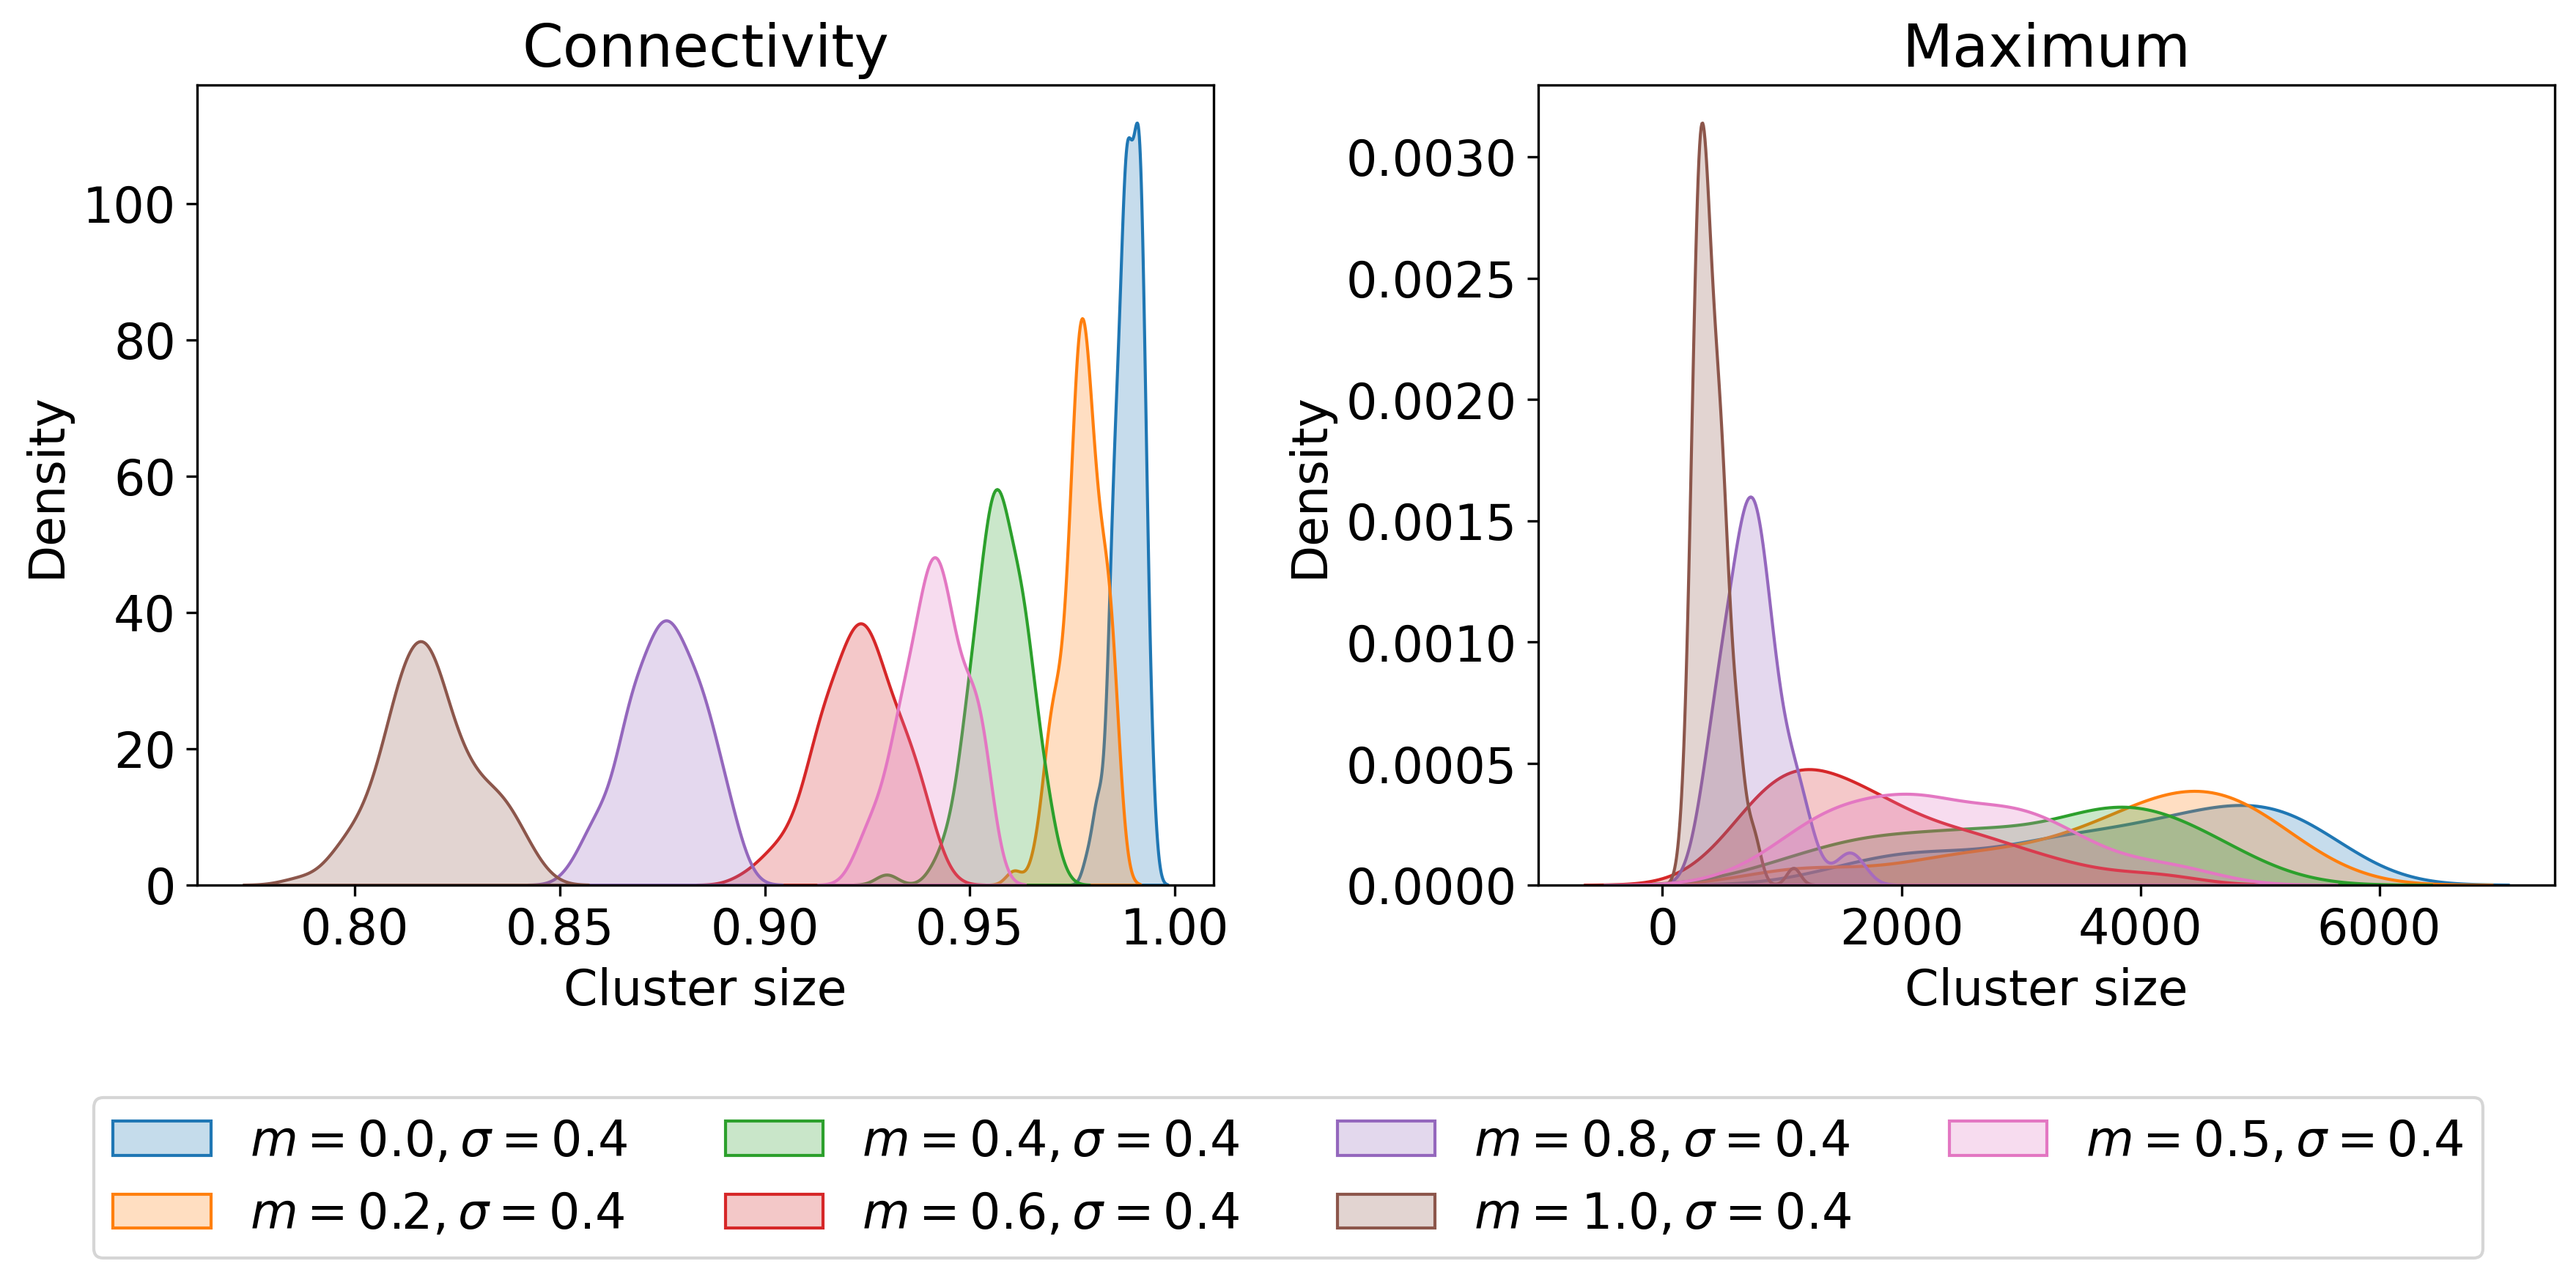

In [15]:
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

methods = ("connectivity", "maximum")
limits = ([0.6, 1.1], None)
for method, axis, lim in zip(methods, ax.flatten(), limits):
    for key in resultsBlocks.keys():
        if key in ("Uniform(0.25, 0.75)", "Uniform(0.5, 1.0)"):
            continue
        if ".2)" in key: continue
        
        sns.kdeplot(getattr(resultsBlocks[key]["+"], method), label=get_label(key) if method != "connectivity" else None, ax=axis,
                   fill=True)
        #axis.set_xlim(lim)
        #axis.set_ylim([0, 200])
        #axis.legend()
        axis.set_xlabel("Cluster size")
        axis.set_title(method.capitalize())
        
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -.005), ncol=4)
plt.gcf().set_dpi(300)
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

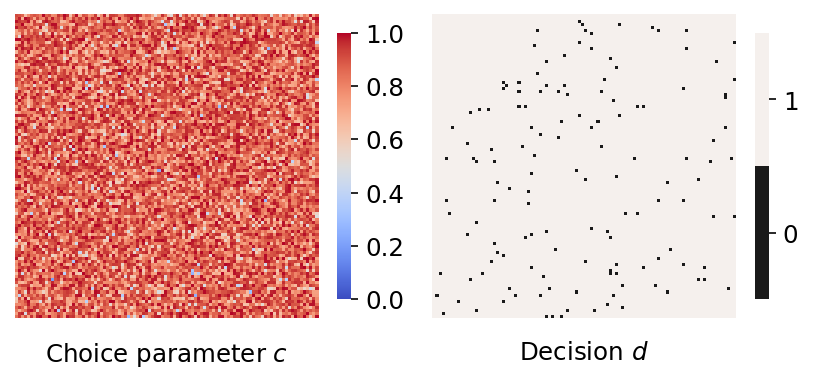

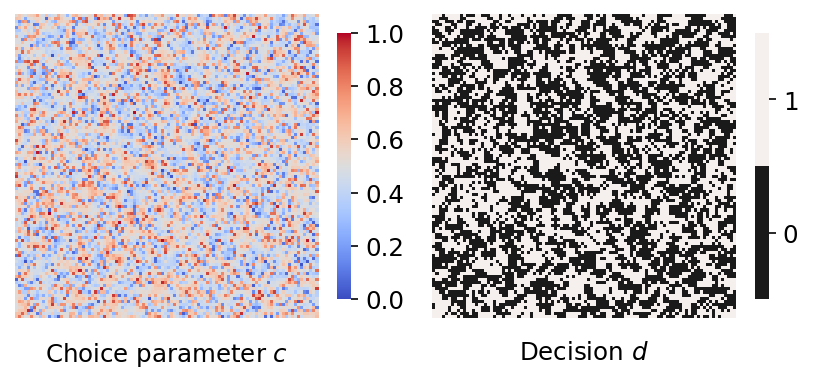

In [346]:
file = "../data/distributions/agent_data_1000steps_a-normal-10-02.csv"
data = LoadSimulation(file, columns=columns)
data = data.query("seed == 151")
ShowState(Grid(Avantgarde(data, 0)))
ShowState(Grid(Choice(data, 1000)))

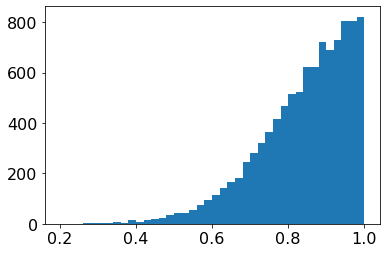

In [302]:
plt.hist(Avantgarde(data, 0), bins=40)
plt.show()

In [106]:
# Cluster size dependence on avantgarde mean / variance

avantgarde_dist = dict()
for _file, dist in files:
    if distribution in avantgarde_dist.keys():
        print("Distribution %s already existent." % distribution)
    elif not os.path.exists(_file):
        print("File %s not found." % _file)
    else:
        _data = LoadSimulation(_file, columns=columns)
        _sample = _data.query("seed == 100")
        _avantgarde = Avantgarde(_sample, 0)
        _true = _avantgarde > 2. / 3
        x = np.sum(_true) / _true.size
        avantgarde_dist[dist] = (np.mean(_avantgarde[_true]) * x, 0)
        
        #(np.mean(_avantgarde), np.var(_avantgarde))
    

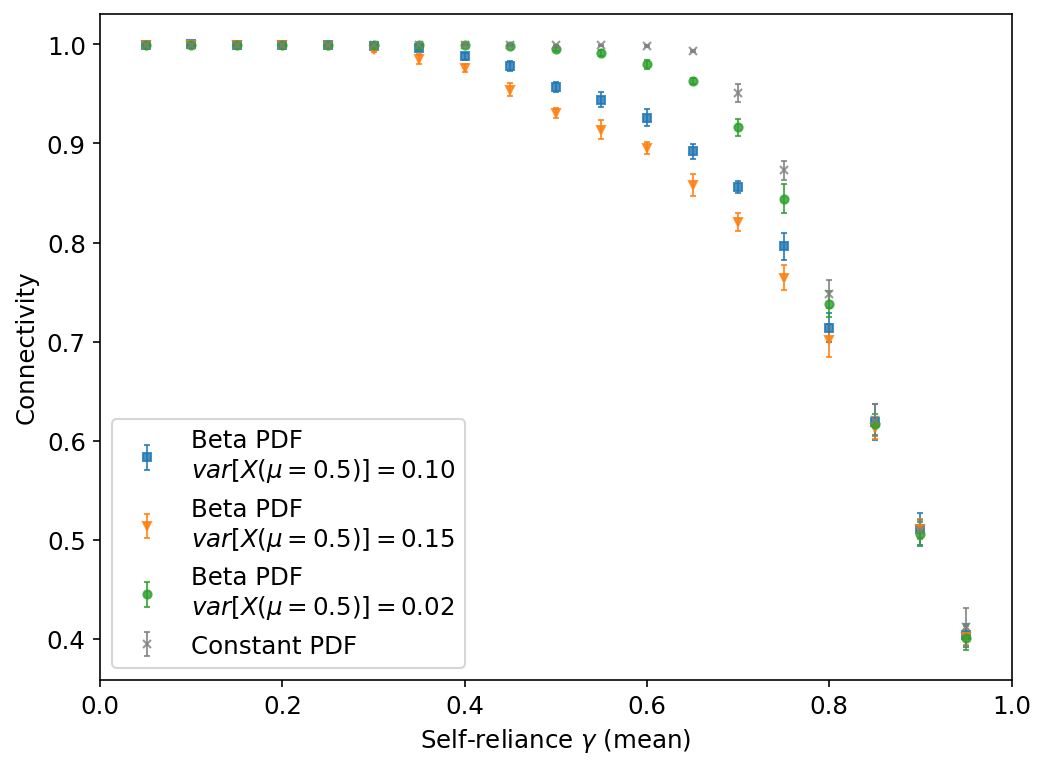

In [69]:
# Plot connectivity
plt.figure(figsize=(8, 6))

plt.gcf().set_dpi(147)
plt.rcParams.update({'font.size': 12})

distributions = [ca.distribution for ca in resultsBlocks]
beta_results = [ca for ca in resultsBlocks if type(ca.distribution) == BetaPdf]
const_results = [ca for ca in resultsBlocks if type(ca.distribution) == ConstantPdf]
for value, color, marker in zip((2., 1.2, 10., 0.0, ), \
                                ("tab:blue", "tab:orange", "tab:green", "tab:grey"), \
                                ("s", "v", "o", "x", )):
    
    if value == 0.0:
        xbeta = [ca.distribution.value for ca in const_results]
        results_filtered = const_results
        label = f"Constant PDF"
    else:
        results_filtered = list(filter(lambda x: x.distribution.alpha == value or \
                                       x.distribution.beta == value, beta_results))

        xbeta = [ca.distribution.mean for ca in results_filtered]
        
        variance_at05 = 1./(2 * (2 * value + 1))
        label = f"Beta PDF\n" + fr"$var[X(\mu=0.5)]={variance_at05:.2f}$"
    
    
    ybeta = [ca.positive.connectivity.stats.mean() for ca in results_filtered]
    yerr_beta = [ca.positive.connectivity.stats.std() for ca in results_filtered]
    
    plt.errorbar(xbeta, ybeta, yerr=yerr_beta,
                 linestyle="", marker=marker, ms=4, elinewidth=1., capsize=1.5, c=color, alpha=0.8,
                 label=label)

plt.xlim([0, 1])
plt.legend(loc="lower left")
plt.xlabel(r"Self-reliance $\gamma}$ (mean)")
plt.ylabel("Connectivity")

plt.show()

Uniform(0.25, 0.75)
Uniform(0.5, 1.0)
Constant(0.0)
Constant(0.1)
Constant(0.2)
Constant(0.3)
Constant(0.4)
Constant(0.5)
Constant(0.6)
Constant(0.7)
Constant(0.8)
Constant(0.9)
Constant(1.0)


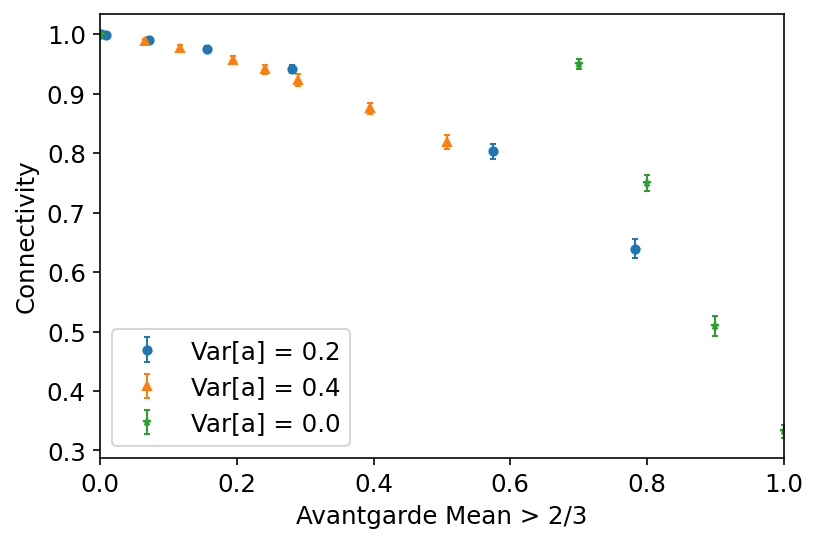

In [110]:
# plot Connectivity
x04, y04, err04 = [], [], []
x02, y02, err02 = [], [], []
xu, yu, erru = [], [], []
xc, yc, errc = [], [], []
for _dist, _cluster in resultsBlocks.items():
    if "Normal" in _dist:
        if "0.4)" in _dist:
            x04.append(avantgarde_dist[_dist][0]) # mean of avantgarde
            y04.append(_cluster["+"].connectivity.mean())
            err04.append(_cluster["+"].connectivity.std())
        elif "0.2)" in _dist:
            x02.append(avantgarde_dist[_dist][0]) # mean of avantgarde
            y02.append(_cluster["+"].connectivity.mean())
            err02.append(_cluster["+"].connectivity.std())
    elif "Constant" in _dist:
        print(_dist)
        xc.append(avantgarde_dist[_dist][0]) # mean of avantgarde
        yc.append(_cluster["+"].connectivity.mean())
        errc.append(_cluster["+"].connectivity.std())
    else:
        print(_dist)
        xu.append(avantgarde_dist[_dist][0]) # mean of avantgarde
        yu.append(_cluster["+"].connectivity.mean())
        erru.append(_cluster["+"].connectivity.std())

plt.figure(figsize=(6, 4))

plt.errorbar(x02, y02, yerr=err02,
             linestyle="", marker="o", ms=4, elinewidth=1., capsize=1.5, color="tab:blue",
             label="Var[a] = 0.2")
plt.errorbar(x04, y04, yerr=err04,
             linestyle="", marker="^", ms=4, elinewidth=1., capsize=1.5, color="tab:orange",
             label="Var[a] = 0.4")
plt.errorbar(xc, yc, yerr=errc,
             linestyle="", marker="*", ms=4, elinewidth=1., capsize=1.5, color="tab:green",
             label="Var[a] = 0.0")
# plt.errorbar(xu, yu, yerr=erru,
#              linestyle="", marker=".", elinewidth=0.5, capsize=1.5, color="tab:red",
#              label="Uniform")

plt.xlim([0, 1])
plt.legend(loc="lower left")
plt.gcf().set_dpi(147)
plt.rcParams.update({'font.size': 12})
plt.xlabel("Avantgarde Mean > 2/3")
plt.ylabel("Connectivity")

plt.show()

In [27]:
results_constant_detailed = [ca for ca in resultsBlocks if type(ca.distribution) == ConstantPdf]

path = "../data/constant_avantgarde/"
for a in np.arange(0.00, 1.01, 0.03)[:]:
    distribution = ConstantPdf(np.round(a, 2))
    AddDistributionConstantAvantgarde(results_constant_detailed, distribution, path)

Distribution ConstantPdf(value=0.15) already existent.
Distribution ConstantPdf(value=0.3) already existent.
Distribution ConstantPdf(value=0.45) already existent.
Distribution ConstantPdf(value=0.6) already existent.
Distribution ConstantPdf(value=0.75) already existent.
Distribution ConstantPdf(value=0.9) already existent.


In [28]:
results_constant_detailed[0].positive.median

Median: [3.391e+03 4.500e+00 2.640e+02 6.620e+03 2.361e+03 1.000e+00 2.240e+02
 6.337e+03 4.510e+02 1.982e+03 2.361e+03 4.500e+00 4.500e+00 2.800e+01
 2.800e+01]

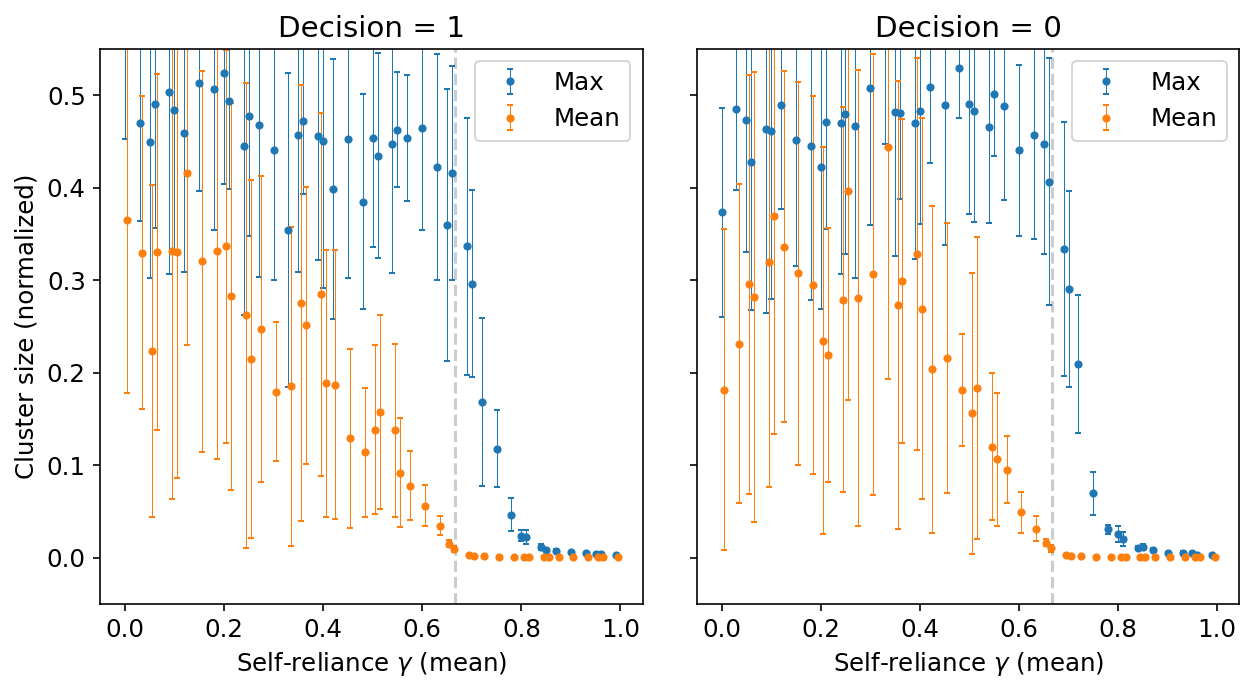

In [41]:
# prepare data
N = 10000
scale = 1.0 / N
_data = results_constant_detailed

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
fig.subplots_adjust(wspace=0.1)

offset=0.005

axes[0].errorbar(x=[analysis.distribution.value for analysis in _data], 
                 y=[analysis.positive.maximum.stats.mean() * scale for analysis in _data],
                 yerr=[analysis.positive.maximum.stats.std() * scale / np.sqrt(1) for analysis in _data], 
                 color="tab:blue", linestyle="", marker=".", 
                 elinewidth=0.5, capsize=1.5, label="Max")

axes[0].errorbar(x=[analysis.distribution.value+offset for analysis in _data], 
                 y=[analysis.positive.mean.stats.mean() * scale for analysis in _data],
                 yerr=[analysis.positive.mean.stats.std() * scale / np.sqrt(1) for analysis in _data], 
                 color="tab:orange", linestyle="", marker=".", 
                 elinewidth=0.5, capsize=1.5, label="Mean")

axes[1].errorbar(x=[analysis.distribution.value for analysis in _data], 
                 y=[analysis.negative.maximum.stats.mean() * scale for analysis in _data],
                 yerr=[analysis.negative.maximum.stats.std() * scale / np.sqrt(1) for analysis in _data], 
                 color="tab:blue", linestyle="", marker=".", 
                 elinewidth=0.5, capsize=1.5, label="Max")

axes[1].errorbar(x=[analysis.distribution.value+offset for analysis in _data], 
                 y=[analysis.negative.mean.stats.mean() * scale for analysis in _data],
                 yerr=[analysis.negative.mean.stats.std() * scale / np.sqrt(1) for analysis in _data], 
                 color="tab:orange", linestyle="", marker=".", 
                 elinewidth=0.5, capsize=1.5, label="Mean")

for ax in axes:
    ymin, ymax = -0.1 / 2, 1.1 / 2
    ax.vlines(2./3, ymin, ymax, colors="black", linestyles="dashed", alpha=0.2)
    ax.set_ylim([ymin, ymax])
    ax.legend()
    ax.set_xlabel(r"Self-reliance $\gamma$ (mean)")

axes[0].set_ylabel("Cluster size (normalized)")
axes[0].title.set_text("Decision = 1")
axes[1].title.set_text("Decision = 0")

plt.show()

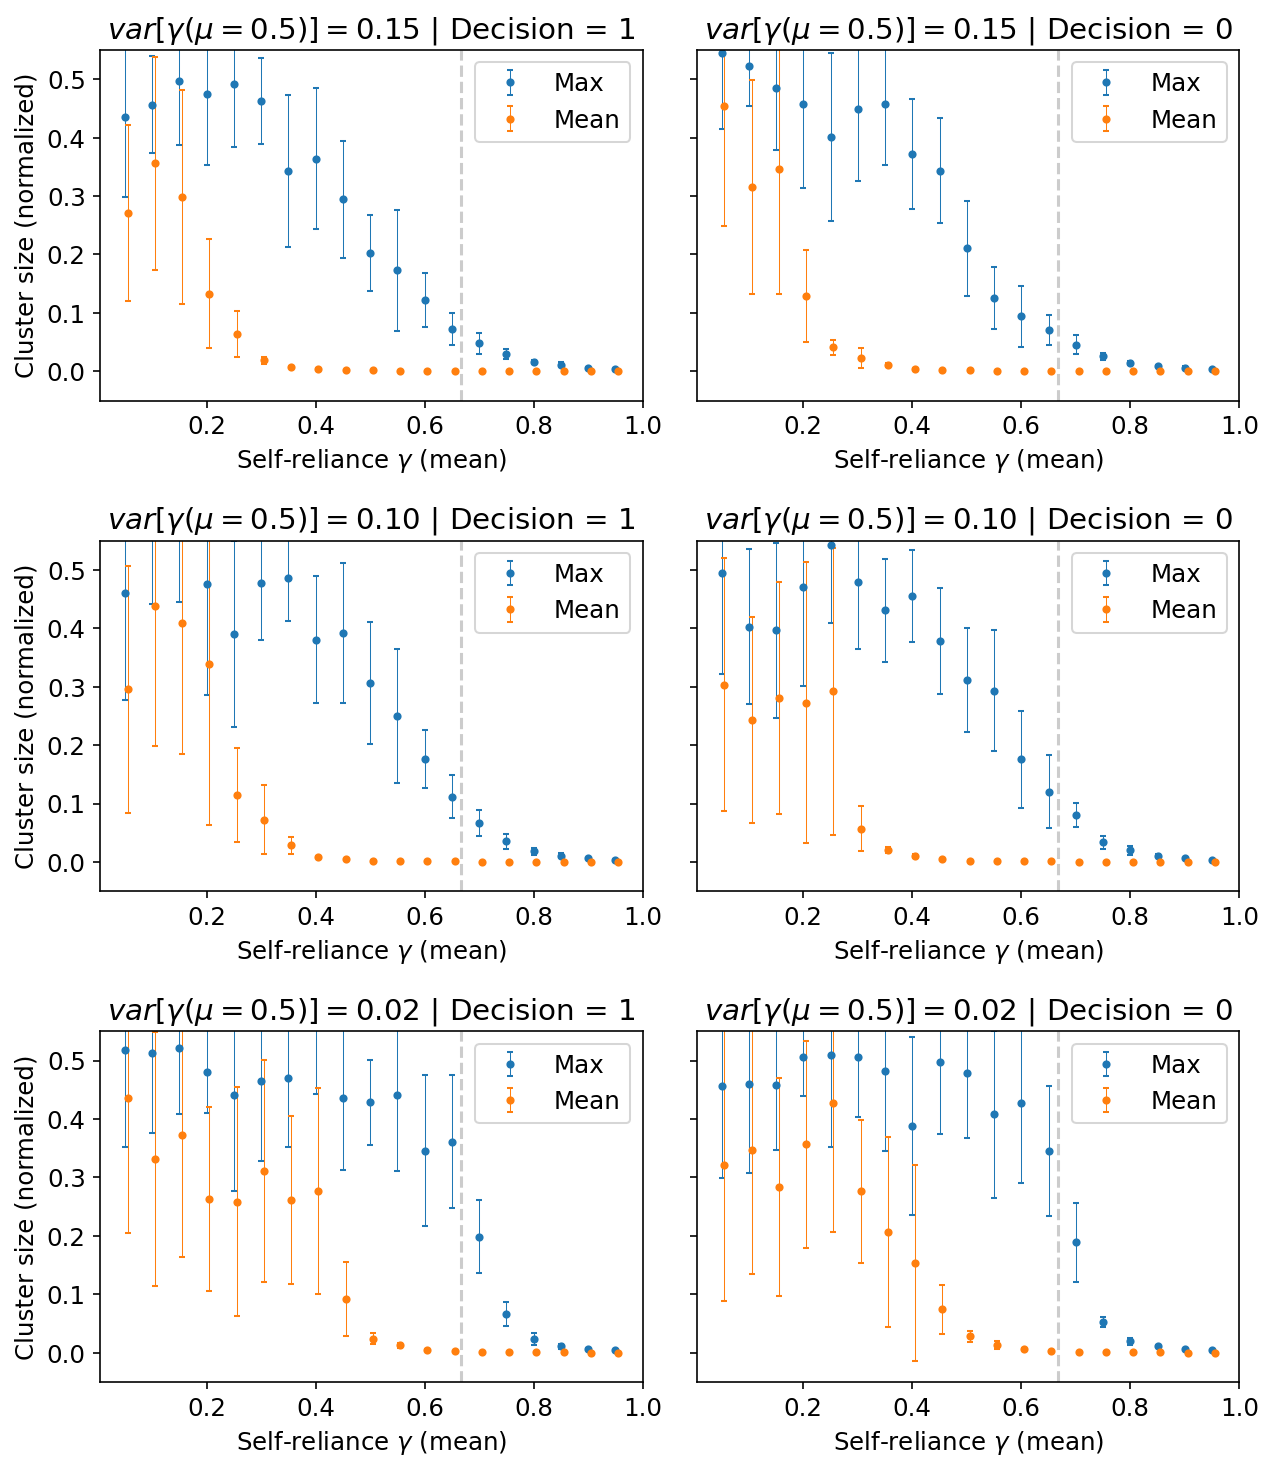

In [59]:
# prepare data
N = 10000
scale = 1.0 / N

def Plot(value, axes):
    _data = list(filter(lambda x: x.distribution.alpha == value or \
                        x.distribution.beta == value, beta_results))

    offset=0.005

    axes[0].errorbar(x=[analysis.distribution.mean for analysis in _data], 
                     y=[analysis.positive.maximum.stats.mean() * scale for analysis in _data],
                     yerr=[analysis.positive.maximum.stats.std() * scale / np.sqrt(1) for analysis in _data], 
                     color="tab:blue", linestyle="", marker=".", 
                     elinewidth=0.5, capsize=1.5, label="Max")

    axes[0].errorbar(x=[analysis.distribution.mean+offset for analysis in _data], 
                     y=[analysis.positive.mean.stats.mean() * scale for analysis in _data],
                     yerr=[analysis.positive.mean.stats.std() * scale / np.sqrt(1) for analysis in _data], 
                     color="tab:orange", linestyle="", marker=".", 
                     elinewidth=0.5, capsize=1.5, label="Mean")

    axes[1].errorbar(x=[analysis.distribution.mean for analysis in _data], 
                     y=[analysis.negative.maximum.stats.mean() * scale for analysis in _data],
                     yerr=[analysis.negative.maximum.stats.std() * scale / np.sqrt(1) for analysis in _data], 
                     color="tab:blue", linestyle="", marker=".", 
                     elinewidth=0.5, capsize=1.5, label="Max")

    axes[1].errorbar(x=[analysis.distribution.mean+offset for analysis in _data], 
                     y=[analysis.negative.mean.stats.mean() * scale for analysis in _data],
                     yerr=[analysis.negative.mean.stats.std() * scale / np.sqrt(1) for analysis in _data], 
                     color="tab:orange", linestyle="", marker=".", 
                     elinewidth=0.5, capsize=1.5, label="Mean")

    for ax in axes:
        ymin, ymax = -0.1 / 2, 1.1 / 2
        ax.vlines(2./3, ymin, ymax, colors="black", linestyles="dashed", alpha=0.2)
        ax.set_ylim([ymin, ymax])
        ax.legend()
        ax.set_xlabel(r"Self-reliance $\gamma$ (mean)")

    var = 1./(2 * (2 * value + 1))
    axes[0].set_ylabel("Cluster size (normalized)")
    axes[0].title.set_text(fr"$var[\gamma(\mu=0.5)]={var:.2f}$ | Decision = 1")
    axes[1].title.set_text(fr"$var[\gamma(\mu=0.5)]={var:.2f}$ | Decision = 0")

fig, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=(10, 12), sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.4)
Plot(1.2, ax1)
Plot(2.0, ax2)
Plot(10.0, ax3)
    
plt.show()

In [76]:
aa = np.linspace(0.01, 1.0, 100)
keys = [*range(1, 20)]

# init cluster props
all_props_pos = [ClusterProperties() for a in aa[:]]
all_props_neg = [ClusterProperties() for a in aa[:]]
    
for k in keys:
    columns = ['id','avantgarde', 'affinity', 'affinityGoal', 'step']
    file = f"../data/constant_avantgarde/agent_data_800steps_{k}.csv"
    data = LoadSimulation(file, columns)
    step = 800
    
    for j, a in enumerate(aa[:]):
        a = np.round(a, 2)

        # >--- get cluster sizes
        grid_data = Grid(Choice(data.query("avantgarde == @a"), step))
        labeled_data = np.digitize(grid_data, bins=np.arange(0, 1, 0.5))
        clusters = CountSizes(labeled_data, skip_size=1, corner_neighbours=False)
        # ---<
        
        # save data
        AddClusterProperties(all_props_neg[j], clusters[1])
        AddClusterProperties(all_props_pos[j], clusters[2])


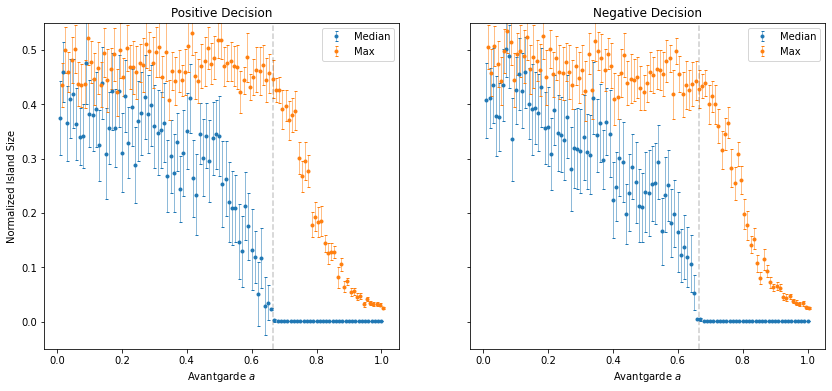

In [77]:
# prepare data
N = 10000
scale = 1.0 / N

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

data = (all_props_pos, all_props_neg)

for ax, all_props in zip(axes, data):
    
    x = np.array(aa)
    y = np.array([np.mean(c.median) for c in all_props]) * scale
    std = np.array([np.std(c.median) for c in all_props]) * scale / np.sqrt(10)

    xmax = np.array(aa)
    ymax = np.array([np.mean(c.maximum) for c in all_props]) * scale
    stdmax = np.array([np.mean(c.maximum) for c in all_props]) * scale / np.sqrt(10)
    
    ax.errorbar(x[::], y[::], yerr=err[::1], 
             linestyle="", marker=".", elinewidth=0.5, capsize=1.5, color="tab:blue",
             label="Median")

    ax.errorbar(xmax[::]+0.005, ymax[::], yerr=errmax[::], 
             linestyle="", marker=".", elinewidth=0.5, capsize=1.5, color="tab:orange",
             label="Max")
#plt.plot(x, y)

    ymin, ymax = -0.1 / 2, 1.1 / 2
    ax.vlines(2./3, ymin, ymax, colors="black", linestyles="dashed", alpha=0.2)

    ax.set_ylim([ymin, ymax])

    ax.legend()
    
    ax.set_xlabel(r"Avantgarde $a$")

axes[0].set_ylabel("Normalized Island Size")

axes[0].title.set_text("Positive Decision")
axes[1].title.set_text("Negative Decision")

plt.show()

Computing embedding
Done.
ward :	0.16s
average :	0.07s
complete :	0.08s
single :	0.03s


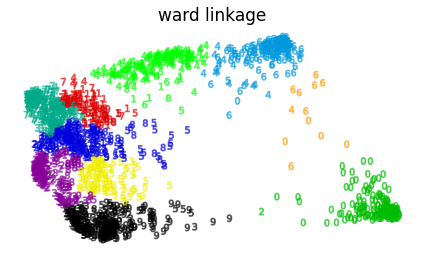

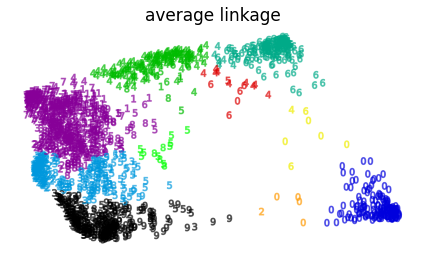

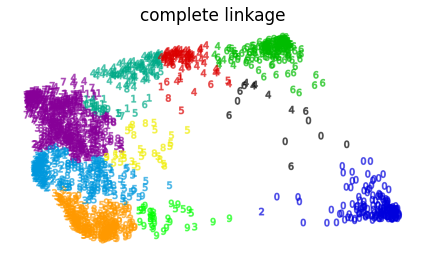

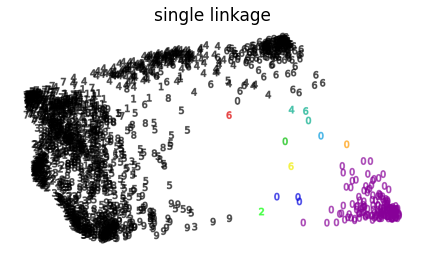

In [1]:
# Authors: Gael Varoquaux
# License: BSD 3 clause (C) INRIA 2014

from time import time

import numpy as np
from matplotlib import pyplot as plt

from sklearn import manifold, datasets

digits = datasets.load_digits()
X, y = digits.data, digits.target
n_samples, n_features = X.shape

np.random.seed(0)


# ----------------------------------------------------------------------
# Visualize the clustering
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for digit in digits.target_names:
        plt.scatter(
            *X_red[y == digit].T,
            marker=f"${digit}$",
            s=50,
            c=plt.cm.nipy_spectral(labels[y == digit] / 10),
            alpha=0.5,
        )

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])


# ----------------------------------------------------------------------
# 2D embedding of the digits dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ("ward", "average", "complete", "single"):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print("%s :\t%.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, clustering.labels_, "%s linkage" % linkage)


plt.show()

In [36]:
file = "../data/distributions/agent_data_1000steps_a-normal-04-04.csv"
data = LoadSimulation(file, columns=columns)

islands = np.digitize(Grid(Choice(sample, 1000)), bins=np.arange(0, 1, 0.5))

In [71]:
X, y = [], []
L = 100
with np.nditer(islands, flags=["multi_index"])as it:
    for x in it:
        X.append([*it.multi_index])
        y.append(x)
    X = np.array(X) * 1./100
    y = np.array(y)

In [72]:
np.array(y)

array([1, 2, 2, ..., 2, 1, 1], dtype=int64)

Computing embedding
Done.
ward :	1.77s
[231 231 231 ...  24  24  24]
average :	1.43s
[ 4  4  4 ... 12 12 12]
complete :	1.37s
[37 37 37 ... 54 54 54]
single :	0.47s
[0 0 0 ... 0 0 0]


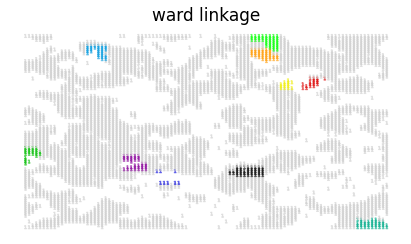

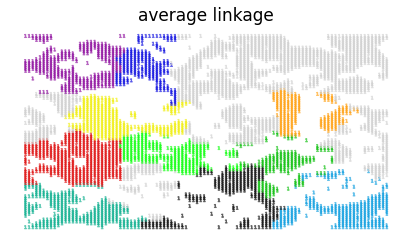

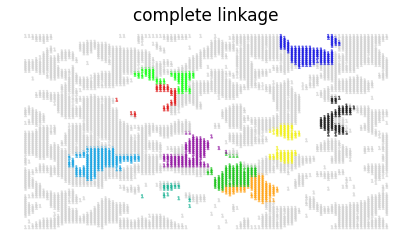

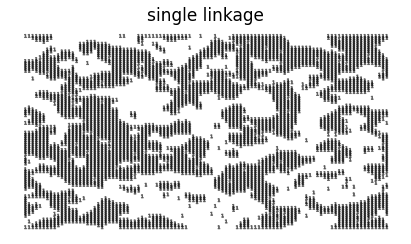

In [98]:
n_samples, n_features = X.shape

np.random.seed(0)


# ----------------------------------------------------------------------
# Visualize the clustering
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)
    
    print(labels)
    plt.figure(figsize=(6, 4))
    for digit in [1]:
        plt.scatter(
            *X_red[y == digit].T,
            marker=f"${digit}$",
            s=10,
            c=plt.cm.nipy_spectral(labels[y == digit] / 10),
            alpha=0.5,
        )

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])


# ----------------------------------------------------------------------
# 2D embedding of the digits dataset
print("Computing embedding")
X_red = X
print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ("ward", "average", "complete", "single"):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=None, compute_full_tree=True, distance_threshold=0.2)
    t0 = time()
    clustering.fit(X_red)
    print("%s :\t%.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, clustering.labels_, "%s linkage" % linkage)


plt.show()

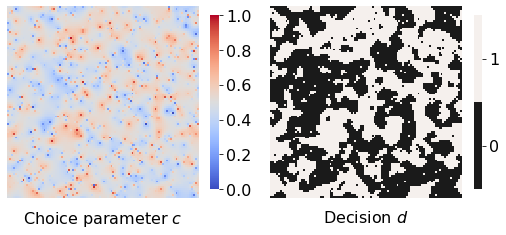

In [94]:
ShowState(Grid(Choice(sample, 1000)).T)

In [191]:
def RowIndex(i, n_columns): 
    return i % n_columns

def ColIndex(i, n_rows): 
    return i % n_rows

def AddCorner(r, c, i, j, data, to_visit):
    Ni = data.shape[0]
    Nj = data.shape[1]
    if data[i, j] != data[RowIndex(i+r, Ni), ColIndex(j+c, Nj)]:
        return
    if data[i, ColIndex(j+c, Nj)] == data[i, j] or data[RowIndex(i+r, Ni), j] == data[i, j]:
        to_visit.append([RowIndex(i+r, Ni), ColIndex(j+c, Nj)])


    
to_visit = []
CheckBlock(-1, 1, 0, 1, np.array([[1, 2, 1],[1, 1, 1], [1, 2, 2]]), to_visit)

to_visit

[[2, 2], [2, 1]]

In [193]:
def CheckBlock(r, c, i, j, data, to_visit):
    Ni = data.shape[0]
    Nj = data.shape[1]
    v = data[i, j]
    ij_others = np.array([[RowIndex(i+r, Ni), ColIndex(j+c, Nj)],
                 [RowIndex(i+r, Ni), j],
                 [i, ColIndex(j+c, Nj)]])
    v_others = np.array([data[_i, _j] for _i, _j in ij_others])
    ij_good = ij_others[v_others == v]
    if ij_good.shape[0] > 1:
        to_visit.extend(ij_good.tolist())

def DFS_strong(i, j, data, visited, value=0, corner_neighbours=True):
    
    nodes_to_visit = [[i, j]]
    size = 0
    
    if visited[i, j] or data[i, j] != value:
        return size
    
    if corner_neighbours:
        rowNeighbours = [-1, -1, -1, 0, 0, 1, 1, 1] # [-1, 0, 0, 1] #
        columnNeighbours = [-1, 0, 1, -1, 1, -1, 0, 1] # [0, -1, 1, 0] #
    else:
        rowNeighbours = [-1, 0, 0, 1] #
        columnNeighbours = [0, -1, 1, 0] #
    
    while len(nodes_to_visit) > 0:
        i, j = nodes_to_visit[0]
        
        if not visited[i, j] and data[i, j] == value:
            
            CheckBlock(-1, -1, i, j, data, nodes_to_visit)
            CheckBlock(-1, 1, i, j, data, nodes_to_visit)
            CheckBlock(1, -1, i, j, data, nodes_to_visit)
            CheckBlock(1, 1, i, j, data, nodes_to_visit)
                
            size += 1
            
        visited[i, j] = 1
        nodes_to_visit.pop(0)
    
    return size

def CountSizes(data, skip_size=0, corner_neighbours=False):
    counts = {key: [] for key in np.unique(data.flatten())}
    dwarfs = []
    for c in counts.keys():
        visited = np.zeros(data.shape)
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                size = DFS_strong(i, j, data, visited, value=c, corner_neighbours=corner_neighbours)
                if size > skip_size:
                    counts[data[i, j]].append(size)
                elif size > 0:
                    dwarfs.append(size)
    return counts, dwarfs

counts, skipped = CountSizes(islands, skip_size=0, corner_neighbours=False)
print(counts)

{1: [21, 8, 13, 3, 11, 89, 48, 7, 13, 1, 12, 1, 102, 1, 95, 1, 3, 61, 44, 1, 6, 1, 13, 1, 36, 4, 1, 1, 1, 24, 13, 6, 1, 1, 1, 4, 1, 1, 6, 1, 1, 5, 1, 1, 5, 4, 1, 1, 1, 1, 3, 1, 1, 1, 8, 1, 1, 1, 1, 1, 3, 1, 1, 6, 9, 3, 6, 1, 1, 1, 1, 3, 18, 1, 31, 1, 1, 1, 4, 1, 1, 1, 1, 1, 34, 1, 1, 5, 1, 1, 1, 4, 5, 1, 4, 82, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 4, 1, 1, 17, 1, 1, 1, 1, 6, 1, 1, 1, 5, 1, 1, 8, 1, 1, 1, 1, 1, 30, 19, 1, 1, 4, 1, 1, 1, 32, 1, 1, 1, 1, 1, 1, 7, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 8, 32, 44, 1, 6, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 42, 1, 1, 1, 9, 1, 1, 1, 1, 7, 1, 1, 1, 8, 11, 1, 9, 5, 1, 6, 1, 1, 5, 1, 1, 1, 1, 75, 1, 1, 1, 11, 60, 1, 1, 1, 19, 1, 1, 8, 1, 1, 1, 1, 17, 1, 1, 1, 1, 3, 1, 1, 1, 6, 1, 6, 1, 1, 10, 5, 4, 1, 1, 1, 1, 1, 1, 1, 1, 25, 1, 3, 1, 1, 18, 1, 1, 1, 1, 26, 3, 4, 1, 1, 24, 1, 1, 1, 9, 4, 1, 1, 7, 6, 1, 1, 34, 1, 3, 1, 1, 1, 14, 1, 1, 6, 7, 1, 1, 1, 7, 1, 1, 1, 1, 84, 1, 1, 1, 95, 1, 1, 29, 1, 1, 1, 9, 1, 10, 1, 

C:\Users\hoedtke\AppData\Local\Temp/ipykernel_3180/3632923914.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (a1 * b1 + (1-a1)*a2*b2)/(a1 + a2 - a1*a2)


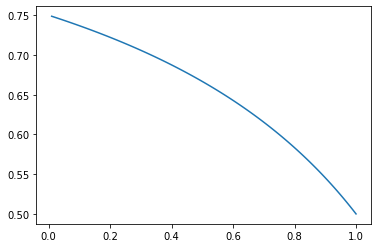

In [39]:
def c1(a1, a2, b1, b2):
    return (a1 * b1 + (1-a1)*a2*b2)/(a1 + a2 - a1*a2)

b1, b2 = 0.5, 1.0
aa = np.linspace(0, 1, 100)
c1 = [c1(a, a, b1, b2) for a in aa]

plt.figure()
plt.plot(aa, c1)
plt.show()

In [ ]:
c1(1, 1,)